# Chi Angles Notebook

This notebook has three main components:
1. Validiating Pyrosetta calculations and exploring chi angle distributions
2. Virtualizing Beta Carbons
3. Reconstructing sidechain conformations from chi angles

```
Author: William Galvin
Since: 2/2023
```

In [1]:
import h5py
import numpy as np
import math
import json
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
### Load neighborhood data from tiny_pdb_dir (25 random pdbs)

filename = "/gscratch/scrubbed/wgalvin/clean_clone/protein_holography-pytorch/protein_holography_pytorch/neighborhoods_tiny.hdf5"

max_atoms = 1000
dt = np.dtype([
    ('res_id','S6', (6)), # S5, 5 (old) ; S6, 6 (new with 2ndary structure)
    ('atom_names', 'S4', (max_atoms)),
    ('elements', 'S1', (max_atoms)),
    ('res_ids', 'S6', (max_atoms, 6)), # S5, 5 (old) ; S6, 6 (new with 2ndary structure)
    ('coords', 'f8', (max_atoms, 3)),
    ('SASAs', 'f8', (max_atoms)),
    ('charges', 'f8', (max_atoms)),
])

with h5py.File(filename, "r") as f:
    data = np.unique(np.array(f['data'], dtype=dt), axis=0)

### Lookup tables
`chi_atoms` is from https://gist.github.com/lennax/0f5f65ddbfa278713f58. 

AA symbol $\Leftrightarrow$ name lookup table from https://www.technologynetworks.com/applied-sciences/articles/essential-amino-acids-chart-abbreviations-and-structure-324357.

`n_chis` from From http://www.mlb.co.jp/linux/science/garlic/doc/commands/dihedrals.html

In [3]:
chi_atoms = dict(
        chi1=dict(
            ARG=['N', 'CA', 'CB', 'CG'],
            ASN=['N', 'CA', 'CB', 'CG'],
            ASP=['N', 'CA', 'CB', 'CG'],
            CYS=['N', 'CA', 'CB', 'SG'],
            GLN=['N', 'CA', 'CB', 'CG'],
            GLU=['N', 'CA', 'CB', 'CG'],
            HIS=['N', 'CA', 'CB', 'CG'],
            ILE=['N', 'CA', 'CB', 'CG1'],
            LEU=['N', 'CA', 'CB', 'CG'],
            LYS=['N', 'CA', 'CB', 'CG'],
            MET=['N', 'CA', 'CB', 'CG'],
            PHE=['N', 'CA', 'CB', 'CG'],
            PRO=['N', 'CA', 'CB', 'CG'],
            SER=['N', 'CA', 'CB', 'OG'],
            THR=['N', 'CA', 'CB', 'OG1'],
            TRP=['N', 'CA', 'CB', 'CG'],
            TYR=['N', 'CA', 'CB', 'CG'],
            VAL=['N', 'CA', 'CB', 'CG1'],
        ),
        chi2=dict(
            ARG=['CA', 'CB', 'CG', 'CD'],
            ASN=['CA', 'CB', 'CG', 'OD1'],
            ASP=['CA', 'CB', 'CG', 'OD1'],
            GLN=['CA', 'CB', 'CG', 'CD'],
            GLU=['CA', 'CB', 'CG', 'CD'],
            HIS=['CA', 'CB', 'CG', 'ND1'],
            ILE=['CA', 'CB', 'CG1', 'CD1'],
            LEU=['CA', 'CB', 'CG', 'CD1'],
            LYS=['CA', 'CB', 'CG', 'CD'],
            MET=['CA', 'CB', 'CG', 'SD'],
            PHE=['CA', 'CB', 'CG', 'CD1'],
            PRO=['CA', 'CB', 'CG', 'CD'],
            TRP=['CA', 'CB', 'CG', 'CD1'],
            TYR=['CA', 'CB', 'CG', 'CD1'],
        ),
        chi3=dict(
            ARG=['CB', 'CG', 'CD', 'NE'],
            GLN=['CB', 'CG', 'CD', 'OE1'],
            GLU=['CB', 'CG', 'CD', 'OE1'],
            LYS=['CB', 'CG', 'CD', 'CE'],
            MET=['CB', 'CG', 'SD', 'CE'],
        ),
        chi4=dict(
            ARG=['CG', 'CD', 'NE', 'CZ'],
            LYS=['CG', 'CD', 'CE', 'NZ'],
        ),
    )

aa_symbols = dict(
    ALA='A', ARG='R', ASN='N', ASP='D', CYS='C', GLN='Q', GLU='E', 
    GLY='G', HIS='H', ILE='I', LEU='L', LYS='K', MET='M', PHE='F', 
    PRO='P', SER='S', THR='T', TRP='W', TYR='Y', VAL='V', PYL='O', SEC='U',
)

## Associtaive both ways
keys = [a for a in aa_symbols.keys()]
for key in keys:
    aa_symbols[aa_symbols[key]] = key 
    
    
n_chi = dict( 
    ALA=0, ARG=4, ASN=2, ASP=2, CYS=1, 
    GLN=3, GLU=3, GLY=0, HIS=2, ILE=2, LEU=2, 
    LYS=4, MET=3, PHE=2, PRO=3, SER=1, THR=1, 
    TRP=2, TYR=2, VAL=1, PYL=2, SEC=2,
)

# associate w/ long name too
keys = [key for key in n_chi]
for key in keys:
    n_chi[aa_symbols[key]] = n_chi[key]

In [4]:
### Utility functions

def split_id(res_id: str):
    return res_id.split("_")

def decode_id(res_id: np.ndarray):
    return [x.decode('utf-8') for x in res_id]

def get_normal_vector(p1, p2, p3):
    v1 = p1 - p2
    v2 = p1 - p3
    x = np.cross(v1, v2)
    return x / np.linalg.norm(x)

---
# Manually calculating chi angles to check pyrosetta's work

There was intitially some concern that pyrosetta was incorrectly calculating chi angles; 
it sometimes reported that residues had more angles than they should, given their type. 

This is a sanity check that pyrosetta is accurately reporting angles, and I believe it is. 

### Notes when running the cell: 
- Execution time is very long; this code is inefficient
- The by-hand way of calculating angles implemented here uses 
$arcos$, which is only defined on $[0, 180]$. However, pyrosetta has a notion
of negative angles. But other than a flipped sign, the calculations align.

In [ ]:

# Load angles calculated earlier by pyrosetta
with open('/gscratch/scrubbed/wgalvin/clean_clone/protein_holography-pytorch/protein_holography_pytorch/angles_tiny.json') as json_file:
    pyrosseta_angles = json.load(json_file)

errors = 0
correct = 0

for i, key in enumerate(tqdm(pyrosseta_angles.keys())):

    target = split_id(key)
    symbol = target[0]

    for chi_num in range(1, 5):
        try:
            chi_atom_labels = chi_atoms[f'chi{chi_num}'][aa_symbols[symbol]]
        except: # not all residue types have all the angles
            continue

        for i in data:
            if (decode_id(i['res_id']) != target): 
                continue

            torsion_atoms = {}
            if 'CA' in chi_atom_labels: 
                torsion_atoms['CA'] = np.zeros(3, dtype=float) # CA is at (0, 0, 0)
            
            for atom, res_id, coords in zip(i['atom_names'],i['res_ids'], i['coords']):
                if (decode_id(res_id) == decode_id(i['res_id'])):
                    atom = atom.decode('utf-8').strip()
                    if atom in chi_atom_labels: 
                        torsion_atoms[atom] = coords
                
        try:
            p1, p2, p3, p4 = [torsion_atoms[a] for a in chi_atom_labels]
        except:
            # not all atoms in neighborhood
            continue

        v1 = get_normal_vector(p1, p2, p3) 
        v2 = get_normal_vector(p2, p3, p4)

        calculated_angle = math.degrees((np.arccos(np.dot(v1, v2))))
        pyrosseta_angle = pyrosseta_angles[key][chi_num - 1]
        
        if abs(pyrosseta_angle - calculated_angle) > 10e-3:
            errors += 1
            print(f"Mine: {calculated_angle}, Pyrosetta: {pyrosseta_angle}, Type: {str(symbol) + str(chi_num)}") # report type and chi num w/ error
        else:
            correct +=1
            
print(f'Accuracy: {correct / correct + errors}')

---
# Plotting Chi Distributions

This plots the probabilty density functions of chi angle distributions, by amino acid type. Note that all axes are the same scale; this causes some spikes to go off plot (or, alternatively, be too flat to read)

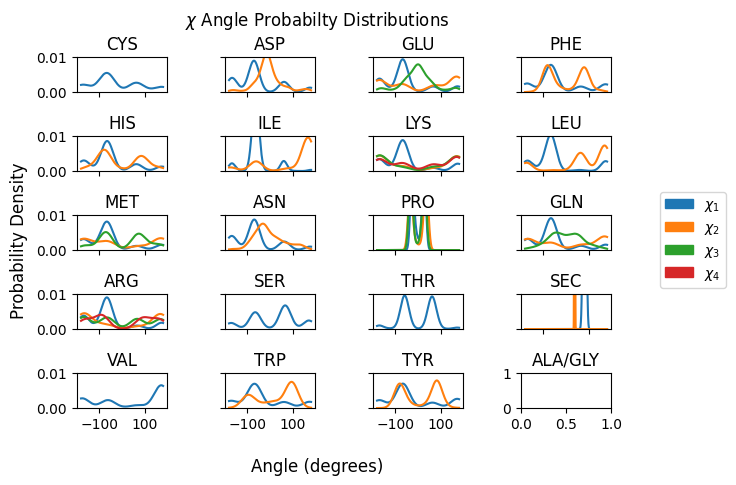

In [5]:
from scipy.stats.kde import gaussian_kde
from numpy import linspace
import matplotlib.patches as mpatches

# Load angles calculated earlier by pyrosetta
with open('/gscratch/scrubbed/wgalvin/clean_clone/protein_holography-pytorch/protein_holography_pytorch/angles_tiny.json') as json_file:
    pyrosseta_angles = json.load(json_file)

angle_distributions = {}
for key, angles in pyrosseta_angles.items():
    key = key[0].upper()
    if key == '_' or key == 'Z': continue
    if key not in angle_distributions:
        angle_distributions[key] = [[] for key in range(0, 4)]
    for i in range(0, n_chi[key]):
        angle_distributions[key][i].append(angles[i])
        
# these are empty
angle_distributions.pop('A')
angle_distributions.pop('G')
    
figure, axis = plt.subplots(5, 4)
figure.suptitle(r'$\chi$ Angle Probabilty Distributions')
figure.supxlabel('Angle (degrees)')
figure.supylabel('Probability Density')
figure.legend(loc="right",bbox_to_anchor=(1.15, .5), handles=[mpatches.Patch(color='tab:blue', label='$\chi_1$'), 
                       mpatches.Patch(color='tab:orange', label='$\chi_2$'),
                       mpatches.Patch(color='tab:green', label='$\chi_3$'), 
                       mpatches.Patch(color='tab:red', label='$\chi_4$')])
plt.tight_layout()

for i, aa_name in enumerate(sorted(angle_distributions)):    
    row = i // 4
    col = i % 4    

    for i in range(n_chi[aa_name]):
        data = angle_distributions[aa_name][i]
        kde = gaussian_kde( data )
        dist_space = linspace(-180, 180, 1000 )
        axis[row, col].plot( dist_space, (kde(dist_space)) )
    axis[row, col].set_title(aa_symbols[aa_name])
    axis[row, col].set_ylim([0, .01])
    axis[row, col].xaxis.set_ticks([-100, 100]) 
    if col != 0: axis[row, col].yaxis.set_ticklabels([])
    if row != 4: axis[row, col].xaxis.set_ticklabels([]) 
axis[4, 3].set_title(f"{aa_symbols['A']}/{aa_symbols['G']}")
figure.savefig("chi_distributions.pdf", bbox_inches="tight")


---
# Placing the Beta Carbons
The CB atoms are not considered part of the backbone, nor are their positions described by chi angles. However, we
need the CB position to construct the rest of the sidechain. 

To place the beta carbons, we need 1) the CA-CB bond length, 2) the N-C-CA bond angle, and 3) the N-C-CA-CB dihedral angle. 
Theses values appear to be constant within amino acid types; that is, all CYS have the same parameters, all ASP have the same parameters, etc. (With
some variation, of course.)

For reference, [this paper](https://onlinelibrary.wiley.com/doi/10.1002/prot.25868) lists the parameters, not grouped by residue type, as
```
CA-CB = 1.521
N-C-CA = 110.4
N-C-CA-CB = 122.55
```

In our data, the mean of those parameters, also not grouped by residue type, are
```
CA-CB = 1.531
N-C-CA = 111.18
N-C-CA-CB = 120.04
```

*For inforation grouped by residue type, see plots below.*

In [46]:
### Collect data on CB parameters described above

with h5py.File(filename, "r") as f:
    data = np.unique(np.array(f['data'], dtype=dt), axis=0)

CA = np.zeros(3, dtype=float)

distances = []
n_c_ca_angles = []
dihedral_angles = []

CA_CB_dict = {}
N_C_CA_dict = {}
N_C_CA_CB_dict = {}

for neighborhood in tqdm(data):
    res_id = decode_id(neighborhood['res_id'])
    AA_type = res_id[0]
    for atom, res_id, coords in zip(neighborhood['atom_names'],neighborhood['res_ids'], neighborhood['coords']):
        if (decode_id(res_id) != decode_id(neighborhood['res_id'])): continue
        atom = atom.decode('utf-8').strip()
        if atom == 'N': N = coords 
        if atom == 'C': C = coords
        if atom == 'CB': CB = coords
        
    # CA-CB distance
    dist = math.dist(CB, CA)
    distances.append(dist)
    if AA_type not in CA_CB_dict:
        CA_CB_dict[AA_type] = []
    CA_CB_dict[AA_type].append(dist)
        
    # N-C-CA
    v1, v2 = N - CA, C - CA
    v1, v2 = v1 / np.linalg.norm(v1), v2 / np.linalg.norm(v2)
    angle = (np.degrees(np.arccos(np.dot(v2, v1))))
    n_c_ca_angles.append(angle)

    if AA_type not in N_C_CA_dict:
        N_C_CA_dict[AA_type] = []
    N_C_CA_dict[AA_type].append(angle)
    
    # N-C-CA-CB
    v1 = get_normal_vector(N, C, CA) 
    v2 = get_normal_vector(C, CA, CB)
    angle = math.degrees((np.arccos(np.dot(v1, v2))))
    dihedral_angles.append(angle)
    
    if AA_type not in N_C_CA_CB_dict:
        N_C_CA_CB_dict[AA_type] = []
    N_C_CA_CB_dict[AA_type].append(angle)

100%|████████████████████████████████████████████████████████████████████████████| 17341/17341 [01:22<00:00, 210.38it/s]


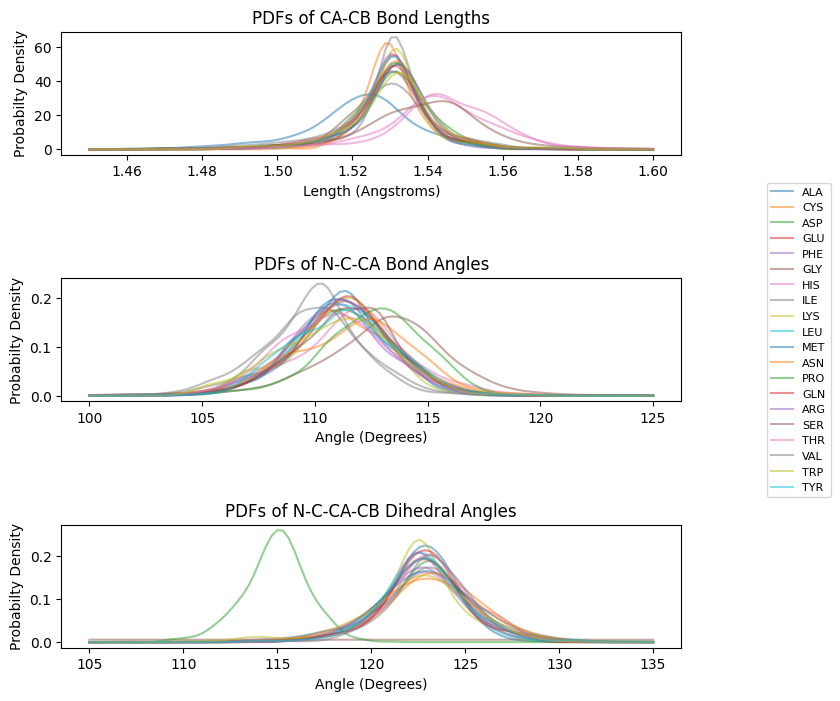

In [77]:
# Plotting CB parameters
fig, axs = plt.subplots(3, figsize=(8, 8))

plt.subplots_adjust(hspace=1)

dist_space = linspace(1.45, 1.6, 100)
for aa in CA_CB_dict:
    if aa == 'G': # G is always exactly 1.53..., making it a point mass with no PDF 
        continue
    kde = gaussian_kde( CA_CB_dict[aa] )
    axs[0].plot(dist_space, kde(dist_space), alpha=.5)
    # axs[0].legend([aa_symbols[a] for a in CA_CB_dict.keys()], fontsize=8)
    axs[0].set_title("PDFs of CA-CB Bond Lengths")
    axs[0].set_xlabel("Length (Angstroms)")
    axs[0].set_ylabel("Probabilty Density")

dist_space = linspace(100, 125, 100)
for aa in N_C_CA_dict:
    kde = gaussian_kde( N_C_CA_dict[aa] )
    axs[1].plot(dist_space, kde(dist_space), alpha=.5)
    # axs[1].legend([aa_symbols[a] for a in N_C_CA_dict.keys()], fontsize=8)
    axs[1].set_title("PDFs of N-C-CA Bond Angles")
    axs[1].set_xlabel("Angle (Degrees)")
    axs[1].set_ylabel("Probabilty Density")

dist_space = linspace(105, 135, 100)
for aa in N_C_CA_CB_dict:
    kde = gaussian_kde( N_C_CA_CB_dict[aa] )
    axs[2].plot(dist_space, kde(dist_space), alpha=.5)
    # axs[2].legend([aa_symbols[a] for a in N_C_CA_CB_dict.keys()], fontsize=8)
    axs[2].set_title("PDFs of N-C-CA-CB Dihedral Angles")
    axs[2].set_xlabel("Angle (Degrees)")
    axs[2].set_ylabel("Probabilty Density")
plt.legend([aa_symbols[a] for a in N_C_CA_CB_dict.keys()], fontsize=8, loc="right",bbox_to_anchor=(1.25, 2.5))


---
# Sidechain Reconstruction

We hypothesize that a sidechain's chi angles uniquely describe its conformation, and aim to reconstruct sidechains
given the positions of backbone atoms and relevant chi angles.

To do so, we must make assumptions about sidechain bond angles and length, both of which have ideal values. 

1. The first cell, below, finds approximations of these ideal values from the data.

2. The next cell contains utility functions for placing the next atom in the sidechain, described by the relevent chi angle. Thanks to [this repo](https://gist.github.com/fasiha/6c331b158d4c40509bd180c5e64f7924#file-rotatevectors-py-L35-L42) for it helpful vector operations.

3. 3rd cell attmepts to reconstruct the sidechains, and records the loss. Change lines 29-31 to use different beta carbon virtualization schemes

4. Plots the results

In [79]:
### Reconstructing angles
# 1 -- find all ideal (median?) bond angles and lengths

with h5py.File(filename, "r") as f:
    data = np.unique(np.array(f['data'], dtype=dt), axis=0)

CA = np.zeros(3, dtype=float)

bond_lengths = {}
bond_angles = {}

for neighborhood in tqdm(data):
    res_id = decode_id(neighborhood['res_id'])
    AA = aa_symbols[res_id[0]]
    
    atoms = {'CA': CA}
    for atom, _res_id, coords in zip(neighborhood['atom_names'],neighborhood['res_ids'], neighborhood['coords']):
        if (decode_id(_res_id) != res_id): continue
        atom = atom.decode('utf-8').strip()
        atoms[atom] = coords
        
    for chi_num in range(1, 5):
        if AA not in chi_atoms[f'chi{chi_num}']: break
        a1, a2, a3, a4 = chi_atoms[f'chi{chi_num}'][AA]
        if a2 not in atoms or a3 not in atoms or a4 not in atoms: # check that all needed atoms are found in neighborhood
            continue
            
        # bond length
        if AA not in bond_lengths: bond_lengths[AA] = [[], [], [], []]
        dist = math.dist(atoms[a3], atoms[a4])
        bond_lengths[AA][chi_num - 1].append(dist)
        
        # a2-a3-a4 bond angles
        if AA not in bond_angles: bond_angles[AA] = [[], [], [], []]
        v1, v2 = atoms[a2] - atoms[a3], atoms[a4] - atoms[a3]
        v1, v2 = v1 / np.linalg.norm(v1), v2 / np.linalg.norm(v2)
        angle = (np.degrees(np.arccos(np.dot(v2, v1))))
        bond_angles[AA][chi_num - 1].append(angle)        
    
ideal_bond_lengths, ideal_bond_angles = {}, {}
for aa in bond_lengths:
    for chi_num in range(4):
        info = bond_lengths[aa][chi_num]
        if len(info) == 0: continue
        ideal_bond_lengths[f'{aa}{chi_num}'] = np.median(info)
        
for aa in bond_angles:
    for chi_num in range(4):
        info = bond_angles[aa][chi_num]
        if len(info) == 0: continue
        ideal_bond_angles[f'{aa}{chi_num}'] = np.median(info)

100%|████████████████████████████████████████████████████████████████████████████| 17341/17341 [00:40<00:00, 431.77it/s]


In [83]:
def get_atom_place(plane_norm, chi_angle, a2, a3, bond_length, bond_angle):
    """
    plane_1_normal -- normal vec of plane described by [a1, a2, a3]
    a2 -- coords of the a2 atom
    a3 -- coords of the a3 atom
    chi angle -- dihedral angle between [a1, a2, a3] and [a2, a3, a4]
    bond_angle -- angle of the a2-a3-a4 bond
    bond_length -- length of the a3-a4 bond
    
    return: coords of a4
    """
    chi_angle, bond_angle = np.deg2rad(90 - chi_angle), np.deg2rad(bond_angle)
    
    vec = rotate_chi(plane_norm, chi_angle, a2, a3, bond_length, bond_angle)
    vec = rotate_bond(a2,a3, vec,bond_angle,bond_length)
    
    return vec

def rotate_chi(plane_norm, chi_angle, a2, a3, bond_length, bond_angle):
    
    # rotate plane normal around a2-a3 by chi 
    a2a3 = a2 - a3
    a2a3 = a2a3/np.linalg.norm(a2a3)
    vec = rotate_about(plane_norm, a2a3, chi_angle)
    
    vec = vec * bond_length + a3
    
    return vec

def rotate_bond(a2, a3, vec, angle, length):
    
    plane_norm = get_normal_vector(a2, a3, vec)
    vec = a2 - a3
    vec = vec/np.linalg.norm(vec)
    vec = rotate_about(vec, plane_norm, -angle)
    vec = vec * length + a3

    return vec


def rmsd(p1, p2):
    _sum = 0
    for q, r in zip(p1, p2):
        _sum += math.pow(q - r, 2)
    _sum /= len(p1)
    return math.sqrt(_sum)

# stolen from https://gist.github.com/fasiha/6c331b158d4c40509bd180c5e64f7924#file-rotatevectors-py-L35-L42

def makeUnit(x):
    """Normalize entire input to norm 1. Not what you want for 2D arrays!"""
    return x / np.linalg.norm(x)


def xParV(x, v):
    """Project x onto v. Result will be parallel to v."""
    # (x' * v / norm(v)) * v / norm(v)
    # = (x' * v) * v / norm(v)^2
    # = (x' * v) * v / (v' * v)
    return np.dot(x, v) / np.dot(v, v) * v


def xPerpV(x, v):
    """Component of x orthogonal to v. Result is perpendicular to v."""
    return x - xParV(x, v)


def xProjectV(x, v):
    """Project x onto v, returning parallel and perpendicular components
    >> d = xProject(x, v)
    >> np.allclose(d['par'] + d['perp'], x)
    True
    """
    par = xParV(x, v)
    perp = x - par
    return {'par': par, 'perp': perp}


def rotate_about(a, b, theta):
    """Rotate vector a about vector b by theta radians."""
    # Thanks user MNKY at http://math.stackexchange.com/a/1432182/81266
    proj = xProjectV(a, b)
    w = np.cross(b, proj['perp'])
    return (proj['par'] +
            proj['perp'] * np.cos(theta) +
            np.linalg.norm(proj['perp']) * makeUnit(w) * np.sin(theta))

In [84]:
with open('/gscratch/scrubbed/wgalvin/clean_clone/protein_holography-pytorch/protein_holography_pytorch/angles_tiny.json') as json_file:
    pyrosseta_angles = json.load(json_file)

losses = {}
    
for neighborhood in tqdm(data):
    
    res_id = decode_id(neighborhood['res_id'])
    AA = aa_symbols[res_id[0]]
    
    if AA not in losses:
        losses[AA] = [[], [], [], []]
        
    if AA in ['ALA', 'GLY']: continue # no Chi angles
    
    chi_angles = pyrosseta_angles['_'.join(res_id)]
    
    atoms = {'CA': np.zeros(3, dtype=float)}
    for atom, _res_id, coords in zip(neighborhood['atom_names'],neighborhood['res_ids'], neighborhood['coords']):
        if (decode_id(_res_id) != res_id): continue
        atom = atom.decode('utf-8').strip()
        atoms[atom] = coords
        
    # virtualize beta carbon
    # mean len = 1.531838310253739, mean dihedral = 120.0424921882685, mean bond angle = 111.18426862786448
    if 'N' not in atoms or'C' not in atoms or 'CA' not in atoms: # check that all needed atoms are found in neighborhood
        continue
    CB_norm = get_normal_vector(atoms['N'], atoms['C'], atoms['CA'])
    # atoms['CB'] = get_atom_place(CB_norm, 120.0424921882685, atoms['C'], atoms['CA'], 1.531838310253739, 111.18426862786448)
    # atoms['CB'] = get_atom_place(CB_norm, 122.55, atoms['C'], atoms['CA'], 1.521, 110.4)
    atoms['CB'] = get_atom_place(CB_norm, np.mean(N_C_CA_CB_dict[aa_symbols[AA]]), 
                                                  atoms['C'], atoms['CA'], 
                                                  np.mean(CA_CB_dict[aa_symbols[AA]]), 
                                                  np.mean(N_C_CA_dict[aa_symbols[AA]]))
        
    for chi_num in range(1, 5):
        if AA not in chi_atoms[f'chi{chi_num}']: break
        a1, a2, a3, a4 = chi_atoms[f'chi{chi_num}'][AA]
        if a2 not in atoms or a3 not in atoms or a4 not in atoms: # check that all needed atoms are found in neighborhood
            continue
        p1_norm = get_normal_vector(atoms[a1], atoms[a2], atoms[a3])
        chi_angle = chi_angles[chi_num - 1]
        bond_length, bond_angle = ideal_bond_lengths[f'{AA}{chi_num - 1}'], ideal_bond_angles[f'{AA}{chi_num - 1}']
        
        predicted_place = get_atom_place(p1_norm, chi_angle, atoms[a2], atoms[a3], bond_length, bond_angle)
        actual_place = atoms[a4]
       
        loss = rmsd(predicted_place, actual_place)
        losses[AA][chi_num - 1].append(loss)
        
        # Use predicted place downstream
        atoms[a4] = predicted_place
                

100%|████████████████████████████████████████████████████████████████████████████| 17341/17341 [00:48<00:00, 355.61it/s]


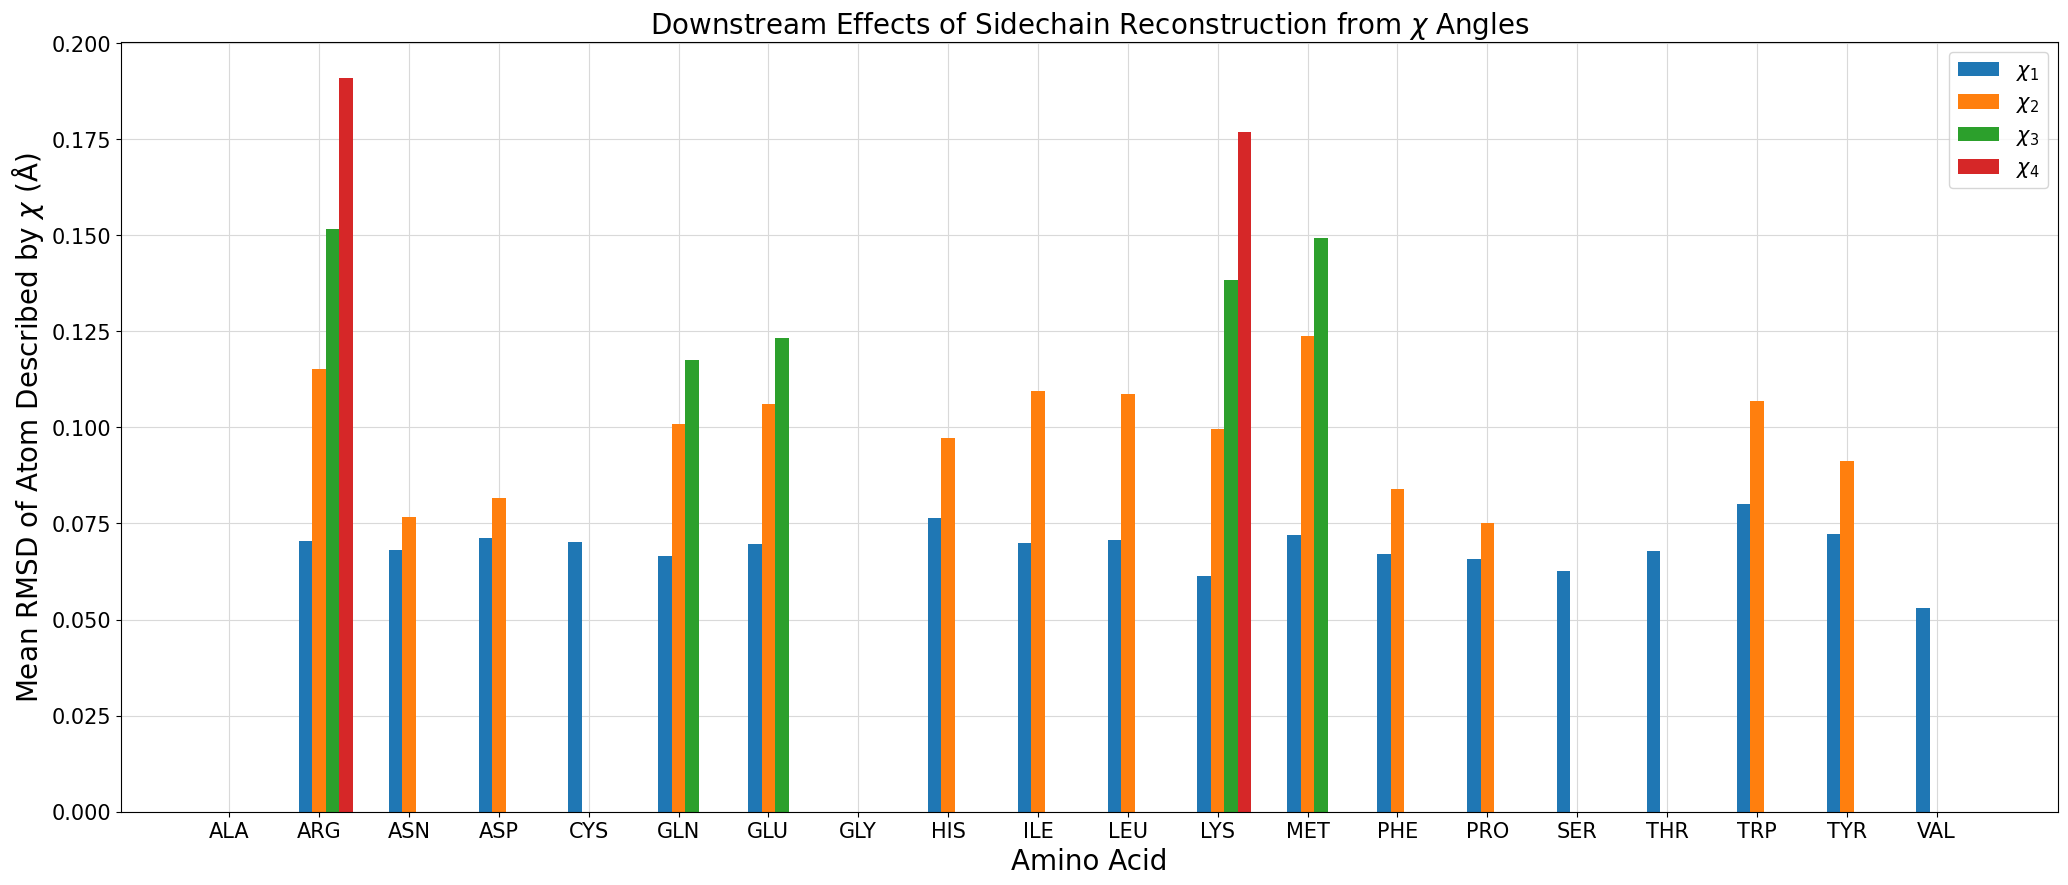

In [86]:

# collect mean loss data
mean_losses = np.zeros((4, len(losses)), dtype=float)
for i, key in enumerate(sorted(losses)):
    for chi in range(0, 4):
        if len(losses[key][chi]) != 0:
            mean_losses[chi][i] = np.mean(losses[key][chi])
        else:
            mean_losses[chi][i] = 0
 
# set width of bar
barWidth = 0.15
fig, ax = plt.subplots(figsize =(25, 10))

ax.set_axisbelow(True)
ax.grid(color=(.85, .85, .85))

 
# Set position of bar on X axis
br1 = np.arange(len(losses))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
 
# Make the plot    
plt.bar(br1, mean_losses[0], color ='tab:blue', width = barWidth,
         label =r'$\chi_1$')
plt.bar(br2, mean_losses[1], color ='tab:orange', width = barWidth,
        label =r'$\chi_2$')
plt.bar(br3, mean_losses[2], color ='tab:green', width = barWidth,
         label =r'$\chi_3$')
plt.bar(br4, mean_losses[3], color ='tab:red', width = barWidth,
         label =r'$\chi_4$')
 
# Adding Xticks
plt.xlabel('Amino Acid', fontsize = 20)
plt.ylabel(r'Mean RMSD of Atom Described by $\chi$ (Å)', fontsize = 20)
plt.xticks([r + barWidth for r in range(len(losses))],
        [x for x in sorted(losses.keys())], fontsize=15)

plt.yticks(fontsize=15) 
plt.legend(fontsize=15)
plt.title(r"Downstream Effects of Sidechain Reconstruction from $\chi$ Angles", fontsize=20)
plt.show()
fig.savefig("downstream_effects.pdf", bbox_inches="tight")